# Práctica 7: Esqueleto de una Infografía en Python

Por **Eduardo Graells-Garrido**. <egraells@udd.cl>. 

Actualizado: **16 de octubre de 2021**.

En este notebook haremos una infografía sobre los viajes de la Encuesta Origen-Destino 2012 de Santiago. Utilizaremos las herramientas que hemos recolectado durante el curso para armar la base de una infografía: los gráficos y sus disposición. Para ello nos apoyaremos en el módulo [Grid Spec](https://matplotlib.org/tutorials/intermediate/gridspec.html) (_especificación de grillas_) de `matplotlib`.

### Objetivo: Ejemplo de Proyecto

#### Título: **¿Cómo se mueven las personas en Santiago?**

En esta infografía de ejemplo para el curso de Visualización de Información exploraremos esta pregunta. Lo haremos a través de un enfoque transversal, es decir, exploraremos diferentes aspectos de la movilidad sin profundizar en alguno de ellos. Para ello nos inspiraremos en el mantra de la búsqueda visual de información:

1. Primero mostraremos una **vista general** de la movilidad en la ciudad (_vista general_ / _overview first_). 
2. Luego mostraremos distintos grupos de **hogares** bajo un criterio definido (_vista filtrada_ / _zoom and filter_).
3. Para cada uno de esos grupos mostraremos distintas visualizaciones con las que podremos comparar sus características **en detalle** (_vista detallada_ / _details on demand_).

#### Fuente de Datos: EOD 2012

Como fuente de datos utilizaremos la Encuesta Origen-Destino de Santiago. Fue recolectada el año 2012 por la Secretaría de Transporte en aproximadamente 100.000 hogares. La hemos utilizado durante el curso a través del módulo AVES en Python. Esta infografía ha sido producida solamente con código en Python, principalmente con los ejemplos de AVES que vimos en las clases prácticas. La excepción es el módulo GridSpec que utilizamos en esta ocasión para componer distintas visualizaciones. 

## Google Colab

Para ejecutar este notebook en Colab, primero ejecuten la siguiente celda. Luego el notebook se reiniciará.

In [1]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

Una vez que se ha reiniciado puedes ejecutar el resto de las celdas.

In [2]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/aves.git aves_git
    !mamba env update --name base --file aves_git/environment-colab.yml
except ModuleNotFoundError:
    pass

## Preámbulo

In [3]:
import sys
from pathlib import Path

AVES_ROOT = Path("..") if not "google.colab" in sys.modules else Path("aves_git")

EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('../data/external/EOD_STGO')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from aves.data import eod, census
import matplotlib as mpl

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 150
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

Cargamos las variables de persona `p`, hogar `h` y viajes `t`.

In [5]:
p = eod.read_people(EOD_PATH)
h = eod.read_homes(EOD_PATH)
t = eod.read_trips(EOD_PATH)

Ahora aplicamos el mismo filtro que utilizamos antes para quedarnos con los viajes dentro del radio urbano:

In [6]:
# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
t = t[(t['SectorOrigen'] != 'Exterior a RM') 
        & (t['SectorDestino'] != 'Exterior a RM')
        & (t['SectorOrigen'] != 'Extensión Sur-Poniente') 
        & (t['SectorDestino'] != 'Extensión Sur-Poniente')
        & pd.notnull(t['SectorOrigen'])
        & pd.notnull(t['SectorDestino'])
        & pd.notnull(t['Proposito'])
]

print(len(t))

89540


Antes considerábamos solamente la representatividad de los viajes en día de semana. Con esto incorporamos sábado y domingo. Para ello debemos considerar el peso o factor de expansión de cada viaje, y también el de cada persona. Por eso mezclamos ambos `DataFrame`:


In [7]:
tp = t.merge(p)

In [8]:
tp['trip_weight'] = tp['FactorLaboralNormal'].fillna(0) + tp['FactorSabadoNormal'].fillna(0) + tp['FactorDomingoNormal'].fillna(0)
tp['person_weight'] = tp['Factor_LaboralNormal'].fillna(0) + tp['Factor_SabadoNormal'].fillna(0) + tp['Factor_DomingoNormal'].fillna(0)
tp['weight'] = tp['trip_weight'] * tp['person_weight']
tp = tp[(tp['weight'] > 0)].copy()
tp['weight'].sum()

37684420.57559812

In [9]:
tph = tp.merge(h)

Consideremos el contexto geográfico utilizando el censo y las áreas urbanas que calculamos en los notebooks anteriores.

In [42]:
comunas = census.read_census_map('comuna', path=AVES_ROOT / "data" / "external" / "censo_2017_R13").to_crs('epsg:5361')
zones = gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json").set_index('ID').to_crs(comunas.crs)

In [43]:
from aves.features.geo import clip_area_geodataframe

In [44]:
comunas_urbanas = (
    comunas[comunas["COMUNA"].isin(zones["Com"].unique())]
    .drop("NOM_COMUNA", axis=1)
    .copy()
)

comunas_urbanas["NombreComuna"] = comunas_urbanas["COMUNA"].map(
    dict(zip(zones["Com"], zones["Comuna"]))
)

comunas_urbanas.head()


,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,SHAPE_Leng,SHAPE_Area,geometry,NombreComuna
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,0.884164,0.021166,"POLYGON ((348666.339 6275861.274, 348652.409 6...",Buin
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,0.720176,0.019124,"POLYGON ((333540.425 6307203.281, 333624.972 6...",Pudahuel
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,0.170180,0.001076,"POLYGON ((340136.215 6301567.277, 340172.841 6...",Cerro Navia
4,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13301,1.692007,0.093820,"POLYGON ((350790.367 6352972.781, 350751.311 6...",Colina
6,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13302,1.046716,0.043569,"POLYGON ((332709.295 6328233.777, 332807.572 6...",Lampa


In [13]:
bounding_box = zones.total_bounds
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=1000)

<AxesSubplot:>

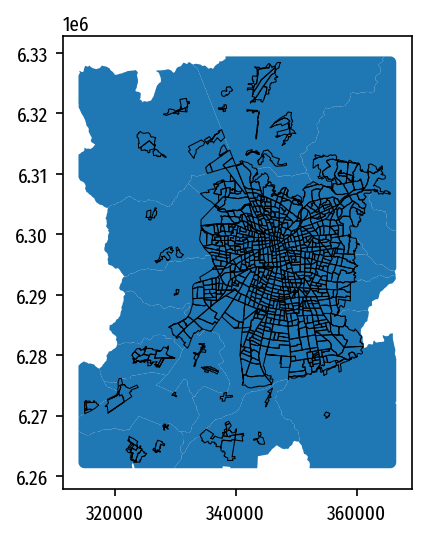

In [14]:
ax = comunas_urbanas.plot()
zones.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

## Vista General de la Movilidad en Santiago

In [15]:
tph['Proposito'].value_counts()

volver a casa                   33024
Al trabajo                      12450
Al estudio                       6321
De compras                       5537
Trámites                         2835
Buscar o Dejar a alguien         2763
Visitar a alguien                2180
Recreación                       1651
De salud                         1516
Otra actividad (especifique)     1181
Por trabajo                      1164
Por estudio                       733
Comer o Tomar algo                386
Buscar o dejar algo               260
Name: Proposito, dtype: int64

In [16]:
from aves.features.utils import normalize_rows

matrix = (
    tph[
        (tph["Proposito"] != "volver a casa")
        & (tph["ComunaOrigen"].isin(comunas_urbanas["NombreComuna"]))
        & (tph["ComunaDestino"].isin(comunas_urbanas["NombreComuna"]))
        & (tph["ComunaOrigen"] != tph["ComunaDestino"])
    ]
    .groupby(["ComunaOrigen", "ComunaDestino"])
    .agg(n_viajes=("trip_weight", "sum"))
    .sort_values("n_viajes", ascending=False)
    .assign(cumsum_viajes=lambda x: x["n_viajes"].cumsum() / x["n_viajes"].sum())
    .pipe(lambda x: x[x["cumsum_viajes"] <= 0.75])
    .reset_index()
)

matrix


,ComunaOrigen,ComunaDestino,n_viajes,cumsum_viajes
0,Maipú,Santiago,504.848790,0.019784
1,Las Condes,Providencia,426.088433,0.036481
2,Ñuñoa,Providencia,390.336342,0.051778
3,Las Condes,Santiago,368.199449,0.066206
4,Vitacura,Las Condes,360.739004,0.080343
...,...,...,...,...
223,Cerro Navia,Providencia,25.626552,0.745588
224,La Granja,Macul,25.573582,0.746591
225,San Bernardo,Providencia,25.505622,0.747590
226,Huechuraba,Las Condes,25.429003,0.748587


In [17]:
matrix['n_viajes'].sum()

19128.062787169998

Recordemos que para crear la red necesitamos asignar un identificador a cada comuna:

In [18]:
from aves.models.network import Network

network = Network.from_edgelist(matrix, source='ComunaOrigen', target='ComunaDestino', weight='n_viajes')
network

In [19]:
from aves.visualization.networks import NodeLink

nodelink = NodeLink(network)
nodelink.layout_nodes(method='geographical', geodataframe=comunas_urbanas, node_column='NombreComuna')

In [20]:
nodelink.set_node_drawing(method='plain', weights=network.node_degree('in'))

In [21]:
nodelink.set_edge_drawing(method='origin-destination')

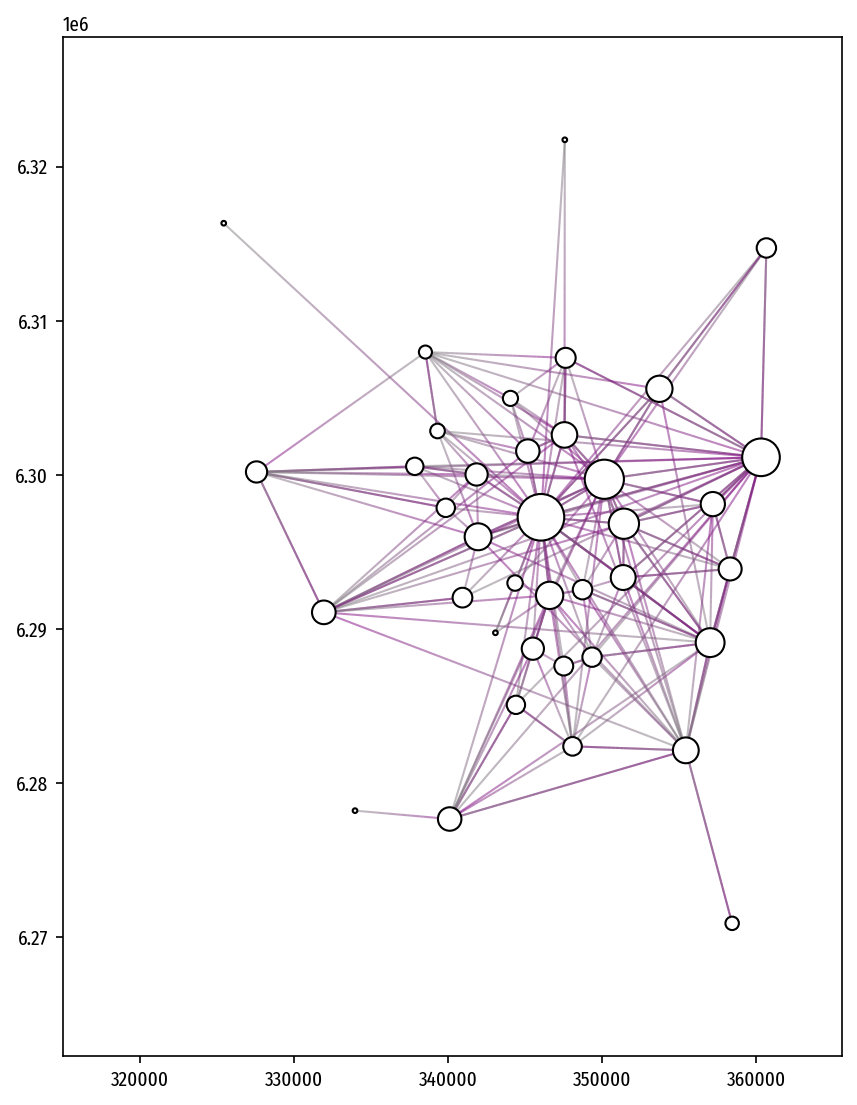

In [22]:
from aves.visualization.figures import figure_from_geodataframe

fig, ax = figure_from_geodataframe(zones, height=9, remove_axes=False)

nodelink.plot(
    ax,
    zorder=1,
    nodes=dict(color="white", edgecolor="black", node_size=500),
    edges=dict(source_color="grey", target_color="purple", alpha=0.5),
)


## Grupos de Hogares

Hasta ahora nuestra unidad de análisis han sido los viajes y los flujos.

En la segunda visualización dividiremos los hogares de Santiago en cinco grupos de acuerdo a su nivel de ingreso.

Utilizaremos el método `qcut` de `pandas`, cuyo nombre significa _quantile cut_ o dividir el `DataFrame` en percentiles. Le pediremos 5 grupos que se almacenarán en la columna `home_category`:

In [23]:
h["home_category"], income_bins = pd.qcut(
    h["IngresoHogar"], 5, labels=[f"Q{i+1}" for i in range(5)], retbins=True
)

h["home_category"].value_counts(sort=False)


Q1    3702
Q2    3604
Q3    3652
Q4    3653
Q5    3653
Name: home_category, dtype: int64

Observamos que el método elige los límites de ingreso de cada grupo de manera que la cantidad de hogares sea similar en cada uno.

In [24]:
income_bins

array([       0. ,   250000. ,   416938.2,   617565. ,   950016. ,
       14800000. ])

Cuando tenemos grupos como estos, una de las primeras preguntas que podemos hacer es: ¿cómo se distribuyen geográficamente estos grupos?¿Están concentrados en ciertas áreas de la ciudad?

Para responderlo, lo primero que debemos hacer es generar un `GeoDataFrame`:

<AxesSubplot:>

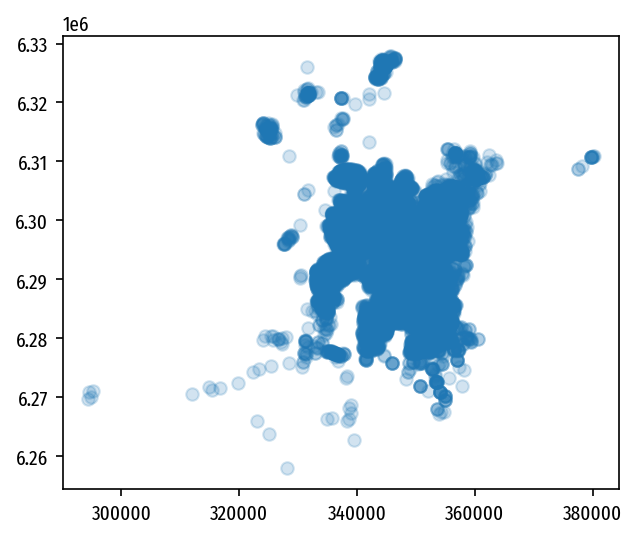

In [25]:
from aves.features.geo import to_point_geodataframe

geo_h = to_point_geodataframe(h[h['Hogar'].isin(tp['Hogar'])], 'DirCoordX', 'DirCoordY', crs='epsg:32719').to_crs(zones.crs)
geo_h.plot(alpha=0.2)

En la clase de mapas vimos que para visualizar distribución geográfica de un conjunto de puntos podemos utilizar un `heat_map`, que nos mostrará "áreas de calor" donde hay mayor concentración de hogares.

Podemos hacer una prueba rápida para ver como luce esta propuesta:

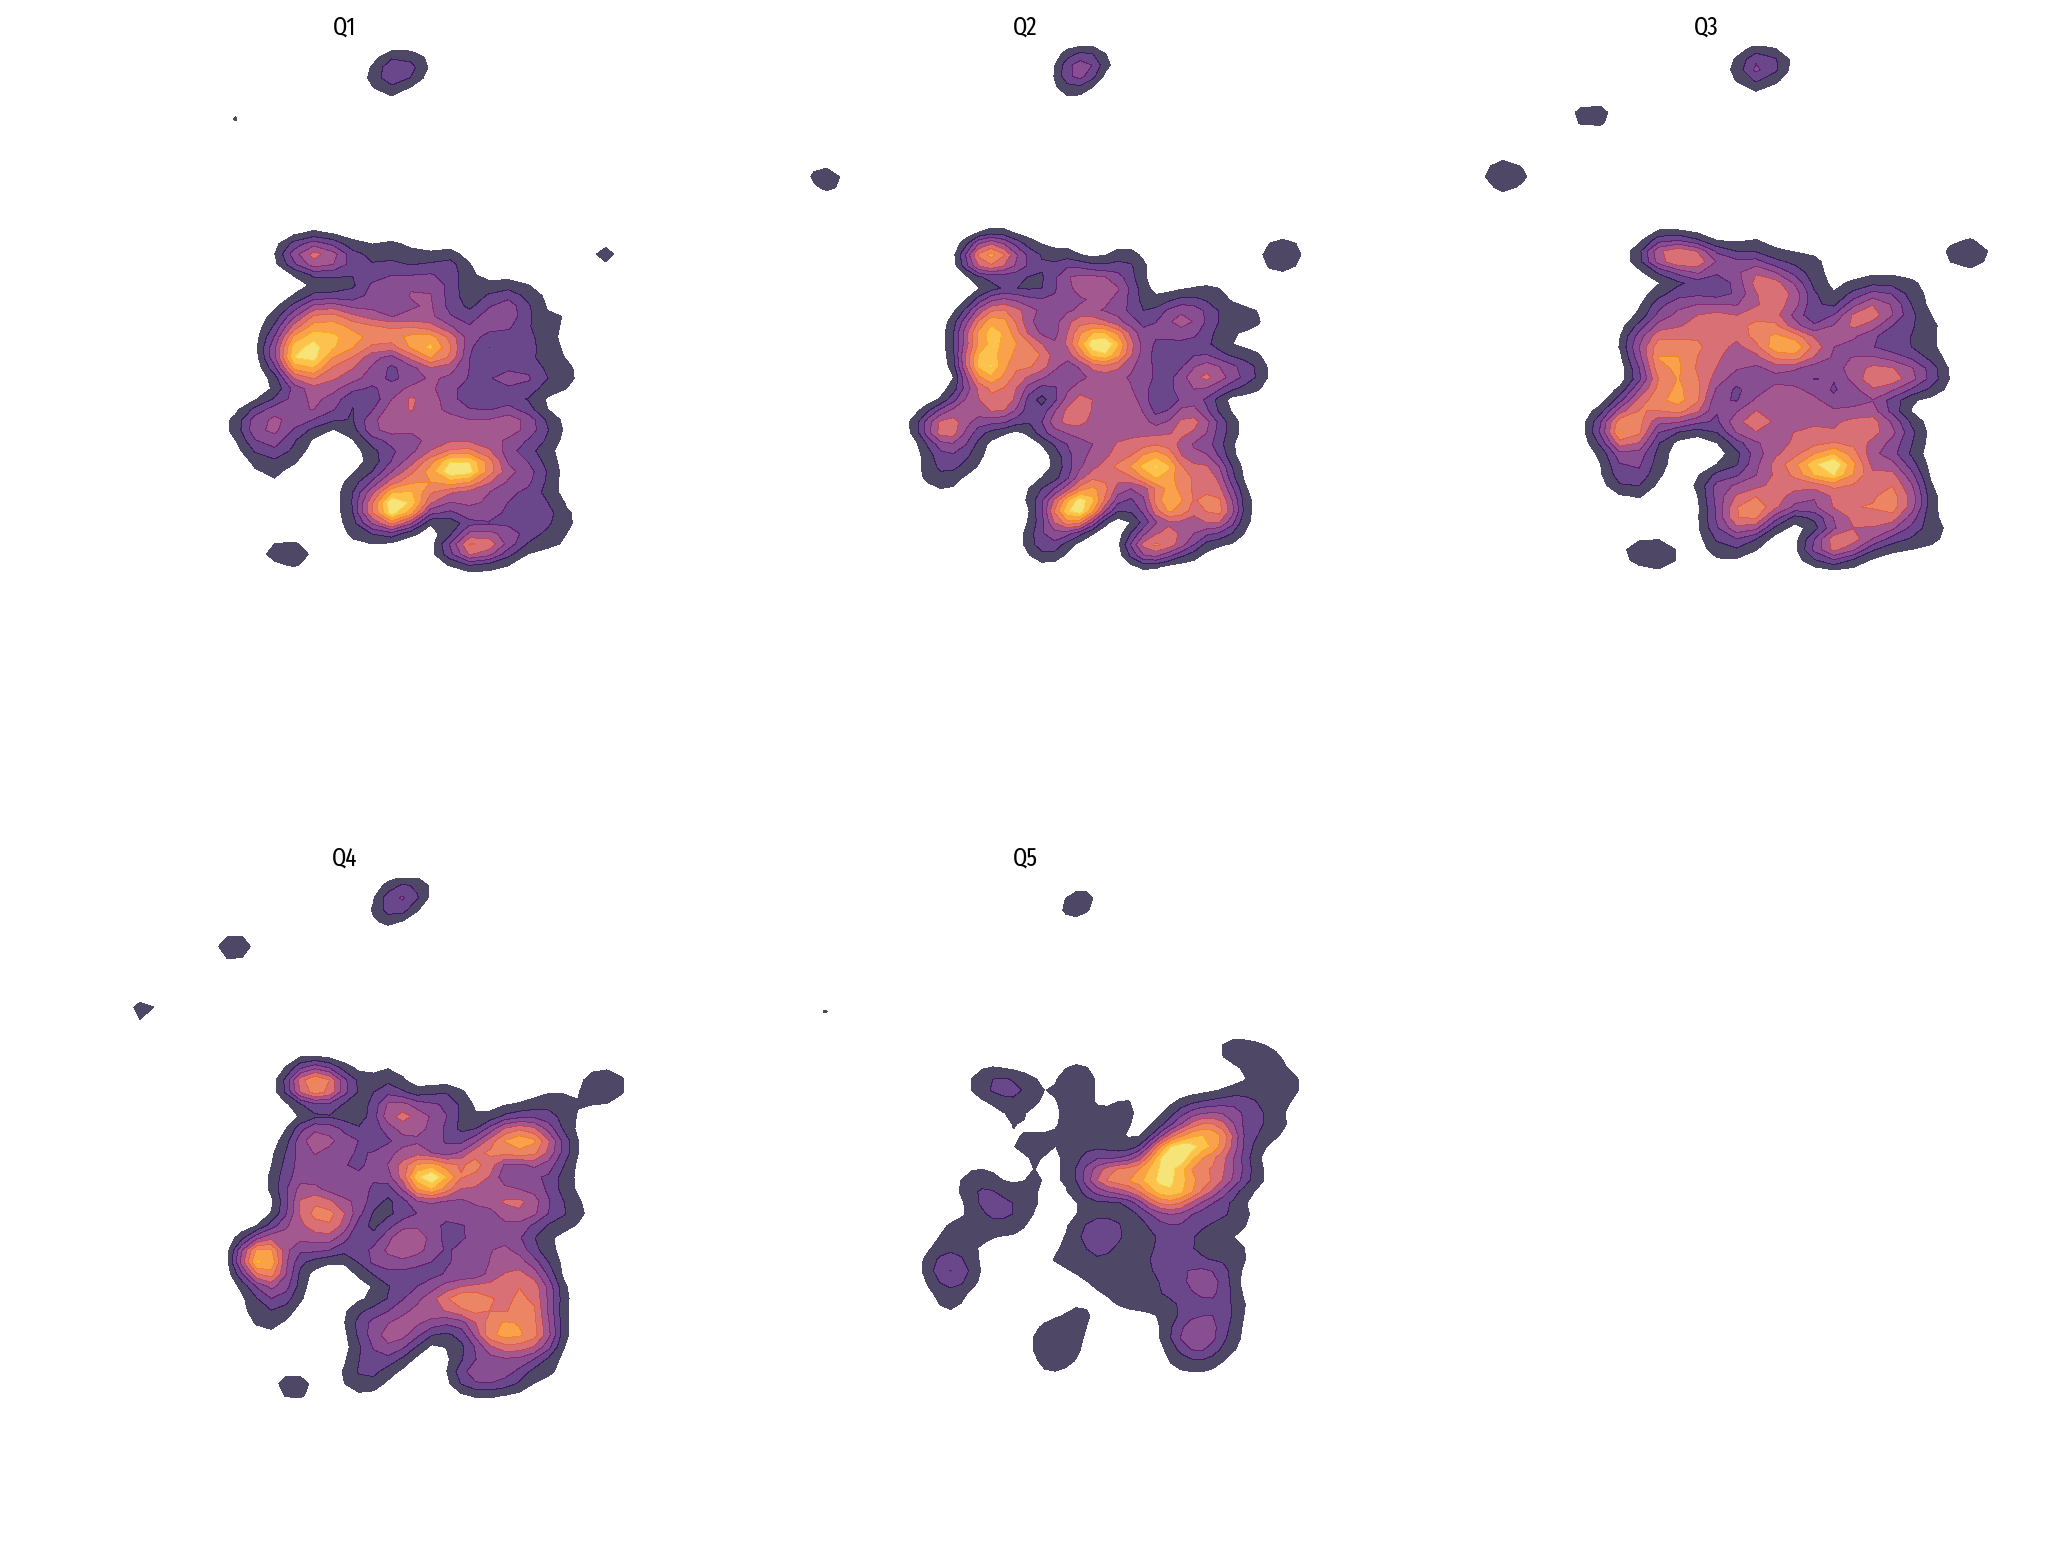

In [26]:
from aves.visualization.figures import small_multiples_from_geodataframe
from aves.visualization.maps import heat_map

fig, axes = small_multiples_from_geodataframe(zones, 5, height=6, col_wrap=3, remove_axes=True)

for ax, home_cat in zip(axes, geo_h['home_category'].cat.categories):
    ax.set_title(home_cat)
      
    temp_geodf = geo_h[geo_h['home_category'] == home_cat]
    
    heat_map(ax, temp_geodf, n_levels=10,
             weight_column='FactorHogar', alpha=0.75, palette='inferno',
             # área de influencia
             bandwidth=1000,
             # no pintar áreas con valores muy bajos
             low_threshold=0.1)

fig.tight_layout()

Lo primero que debemos considerar es que ya no podemos usar los métodos auxiliares para configurar figuras de `aves`, porque no son compatibles con `gridspec`. Así que debemos configurar la grilla manualmente. Por eso necesitamos conocer el _radio de aspecto_ del mapa de Santiago, a partir de la variable `bounding_box` que habíamos calculado antes:

In [27]:
bounding_box

array([ 314984.40368208, 6262284.19771426,  365574.46867127,
       6328434.82686077])

In [28]:
map_aspect_ratio = (bounding_box[2] - bounding_box[0]) / (bounding_box[3] - bounding_box[1])
map_aspect_ratio

0.7647707307083309

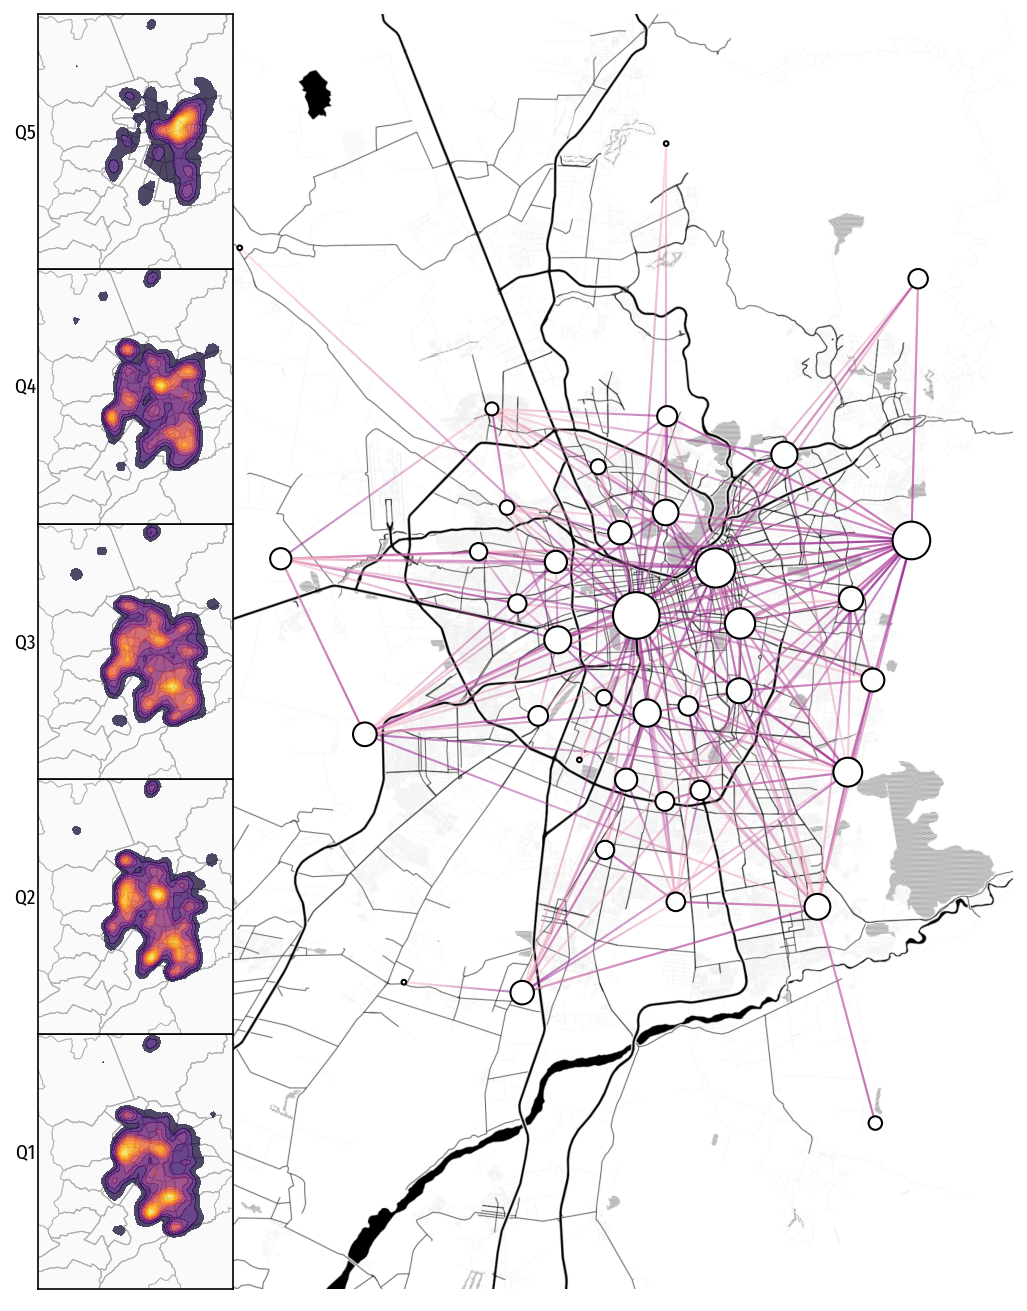

In [29]:
import contextily as cx

height = 9

fig, ax = plt.subplots(figsize=(map_aspect_ratio * height, height))


def plot_maps(ax):
    cx.add_basemap(
        ax,
        crs=comunas_urbanas.crs.to_string(),
        source=AVES_ROOT / "data" / "processed" / "scl_toner_12.tif",
        interpolation="hanning",
        zorder=0,
        reset_extent=False,
    )

    ax.set_xlim([bounding_box[0], bounding_box[2]])
    ax.set_ylim([bounding_box[1], bounding_box[3]])
    ax.set_aspect("equal")

    nodelink.plot(
        ax,
        zorder=1,
        nodes=dict(color="white", edgecolor="black", node_size=500),
        edges=dict(source_color="pink", target_color="purple", alpha=0.5),
    )

    categories = geo_h["home_category"].cat.categories

    for i, cat in enumerate(categories):
        inset_ax = ax.inset_axes(
            [0.0, i / len(categories), 1.0 / len(categories), 1.0 / len(categories)]
        )

        inset_ax.set_xlim([bounding_box[0], bounding_box[2]])
        inset_ax.set_ylim([bounding_box[1], bounding_box[3]])
        inset_ax.set_facecolor("#fafafa")
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_ylabel(f"Q{i+1}  ", rotation=0)

        temp_geodf = geo_h[geo_h["home_category"] == cat]

        comunas_urbanas.plot(
            ax=inset_ax, facecolor="none", edgecolor="#abacab", linewidth=0.5
        )

        heat_map(
            inset_ax,
            temp_geodf,
            n_levels=10,
            weight_column="FactorHogar",
            alpha=0.75,
            palette="inferno",
            # área de influencia
            bandwidth=1000,
            # no pintar áreas con valores muy bajos
            low_threshold=0.1,
        )


plot_maps(ax)

ax.set_axis_off()
fig.tight_layout()


Notamos que sí existe concentración geográfica de los tipos de hogar. Entonces, lo que haremos en nuestra infografía es utilizar estos mapas con dos propósitos. El primero es mostrar la distribución geográfica de los hogares, el segundo es ser leyenda para visualizaciones complementarias para cada uno de estos grupos.

## Detalle #1: Hora de Viaje al Trabajo

Una pregunta que podríamos hacernos respecto a cada grupo es a qué hora se van al trabajo. ¿Cuáles se van más temprano?¿Cuáles más tarde?

In [30]:
tph_categorized = tph.merge(h)
tph_categorized['HoraDeInicio'] = tph_categorized['HoraIni'] / pd.Timedelta(hours=1)

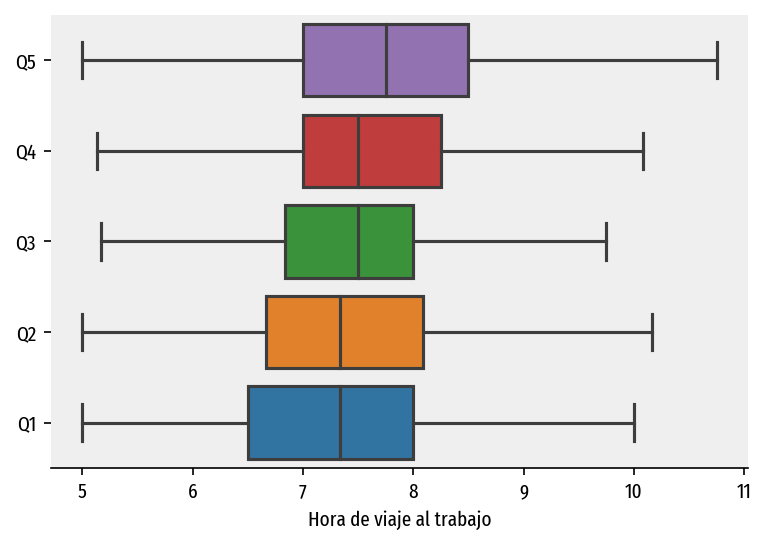

In [31]:
fig, ax = plt.subplots()

def plot_boxplots(ax):
    sns.boxplot(
        x="HoraDeInicio",
        y="home_category",
        data=tph_categorized.pipe(
            lambda df: df[
                (df["Proposito"] == "Al trabajo") & (df["HoraDeInicio"].between(5, 11))
            ]
        ),
        ax=ax,
        order=geo_h["home_category"].cat.categories.sort_values(),
        showfliers=False,
    )

    ax.set_ylim([-0.5, 4.5])
    ax.set_ylabel("")
    ax.set_xlabel("Hora de viaje al trabajo")
    sns.despine(ax=ax, left=True)
    ax.set_facecolor("#efefef")


plot_boxplots(ax)


## Detalle #2: Modos de Viaje

Podríamos preguntarnos si las distintas tipologías de hogares se desplazan de manera distinta por la ciudad. ¿Es el uso de bicicleta distinto por grupos de ingreso?¿El uso de automóvil? Existen preconcepciones al respecto (como que la bicicleta es un modo de transporte de pobres o de hipsters) que podemos aclarar utilizando visualización.

Para obtener la respuesta utilizaremos la columna `ModoDifusion` de los viajes. No trabajaremos con todos los modos, descartaremos los que no podemos saber a qué se refieren ("Otros"):

[Text(-0.5, 0, 'Auto'),
 Text(0.5, 0, 'Bicicleta'),
 Text(1.5, 0, 'Bip!'),
 Text(2.5, 0, 'Caminata'),
 Text(3.5, 0, 'Taxi'),
 Text(4.5, 0, 'Taxi Colectivo')]

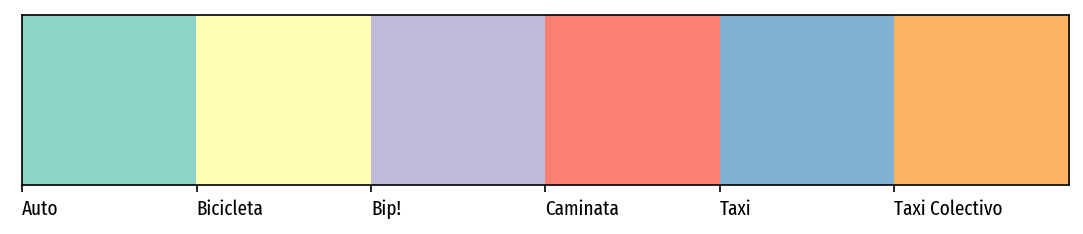

In [32]:
modes = sorted(
    set(tph["ModoDifusion"].unique())
    - set(["Bip! - Otros Privado", "Bip! - Otros Público", "Otros"])
)

mode_colors = sns.color_palette("Set3", n_colors=len(modes))
sns.palplot(mode_colors, size=1.5)
plt.gca().set_xticklabels(modes, ha="left")


Ahora que tenemos identificados los modos que queremos visualizar, y hasta les hemos asignado un color, podemos ver la distribución _parte-de-un-todo_ dentro de cada categoría de hogar utilizando un `stacked_bar_chart`:

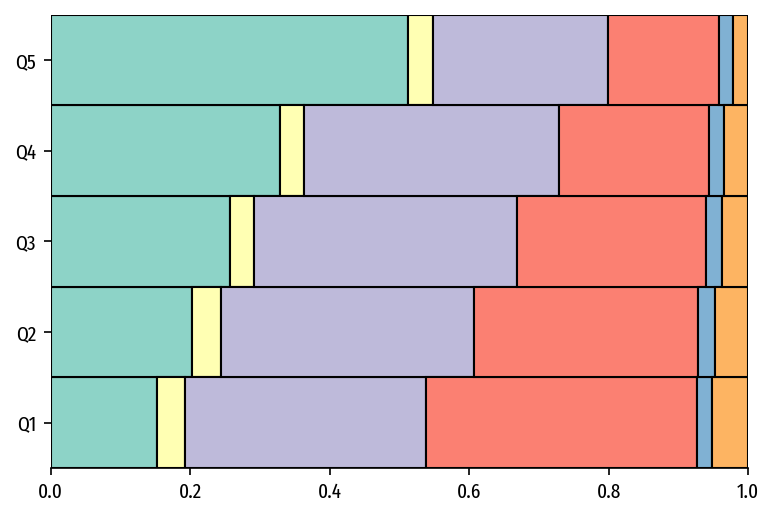

In [33]:
from aves.features.utils import normalize_rows

mode_distributions = (
    tph_categorized.groupby(["home_category", "ModoDifusion"])["trip_weight"]
    .sum()
    .unstack(fill_value=0)[modes]
    .pipe(normalize_rows)
)


def plot_mode_usage(ax):
    mode_distributions.plot(
        kind="barh",
        width=1.0,
        linewidth=1,
        edgecolor="black",
        color=mode_colors,
        stacked=True,
        legend=False,
        ax=ax,
    )
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 4.5])
    ax.set_ylabel("")
    sns.despine(ax=ax, left=True)


fig, ax = plt.subplots()
plot_mode_usage(ax)


## Detalle #3: Propósitos de Viaje

Asimismo, podríamos preguntarnos si las distintas tipologías de hogares tienen _estilos de vida_ distintos. Por ejemplo, ¿la proporción de viajes de recreación en cada categoría de hogar es similar? 

De manera análoga a la visualización anterior utilizaremos la columna `Proposito` de los viajes:

In [34]:
tph['Proposito'].unique()

array(['volver a casa', 'Visitar a alguien', 'Al trabajo', 'Al estudio',
       'De compras', 'Buscar o Dejar a alguien', 'Trámites',
       'Por estudio', 'Otra actividad (especifique)', 'De salud',
       'Recreación', 'Comer o Tomar algo', 'Por trabajo',
       'Buscar o dejar algo'], dtype=object)

Del mismo modo, no trabajaremos con todos los propósitos. Por ejemplo, podemos descartar aquellos cuyo destino no depende de las intenciones de la persona que hace el viaje, o bien, aquellos que son triviales (como volver a casa):

[Text(-0.5, 0, 'Al estudio'),
 Text(0.5, 0, 'Al trabajo'),
 Text(1.5, 0, 'Buscar o Dejar a alguien'),
 Text(2.5, 0, 'Comer o Tomar algo'),
 Text(3.5, 0, 'De compras'),
 Text(4.5, 0, 'De salud'),
 Text(5.5, 0, 'Recreación'),
 Text(6.5, 0, 'Trámites'),
 Text(7.5, 0, 'Visitar a alguien')]

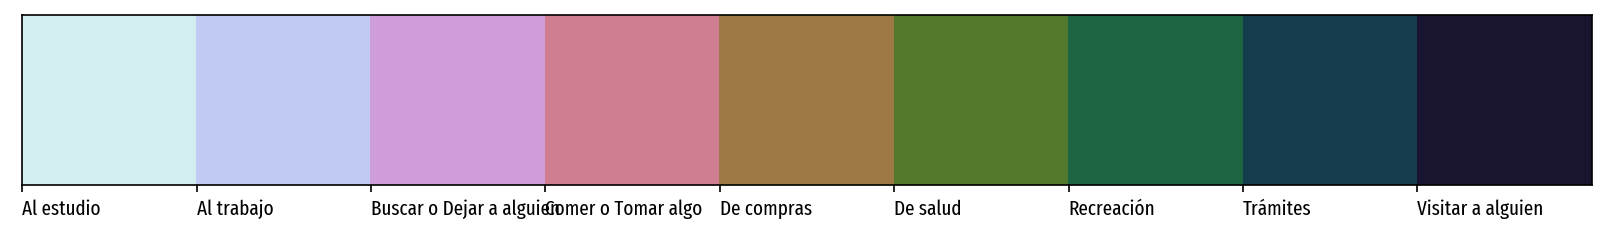

In [35]:
purposes = sorted(
    set(tph["Proposito"].unique())
    - set(
        [
            "Por trabajo",
            "Por estudio",
            "Otra actividad (especifique)",
            "volver a casa",
            "Buscar o dejar algo",
        ]
    )
)

purpose_colors = sns.color_palette("cubehelix_r", n_colors=len(purposes))
sns.palplot(purpose_colors, size=1.5)
plt.gca().set_xticklabels(purposes, ha="left")


Similarmente, ahora que tenemos identificados los propósitos que queremos visualizar, y hasta les hemos asignado un color, podemos ver la distribución _parte-de-un-todo_ dentro de cada categoría de hogar utilizando un `stacked_bar_chart`:

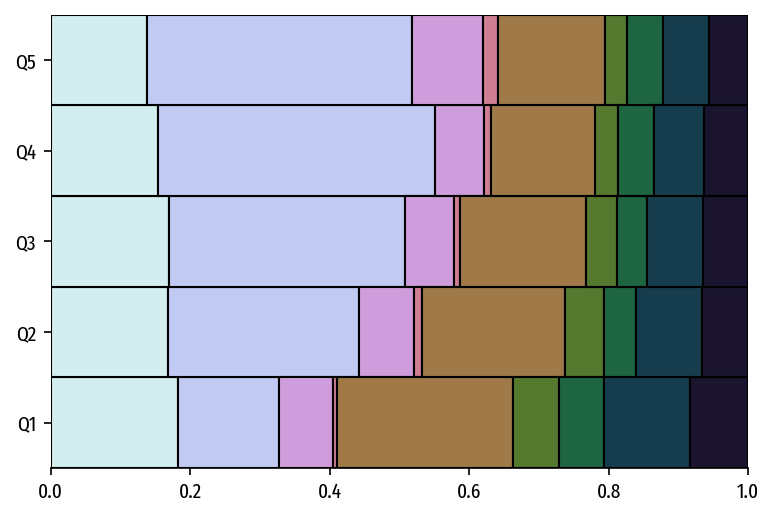

In [36]:
purpose_distributions = (
    tph_categorized.groupby(["home_category", "Proposito"])["trip_weight"]
    .sum()
    .unstack(fill_value=0)[purposes]
    .pipe(normalize_rows)
)


def plot_purposes(ax):
    purpose_distributions.plot(
        kind="barh",
        width=1.0,
        linewidth=1,
        edgecolor="black",
        color=purpose_colors,
        stacked=True,
        legend=False,
        ax=ax,
    )
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 4.5])
    ax.set_ylabel("")
    sns.despine(ax=ax, left=True)


fig, ax = plt.subplots()
plot_purposes(ax)


## Composición de Visualizaciones en una Grilla

En este momento ya tenemos suficientes visualizaciones para organizar en una grilla y crear una narrativa. Pero, ¿cómo lo hacemos en Python?

La respuesta es el módulo `gridspec` que permite especificar una grilla sobre la cual dibujar. Como este notebook busca ejemplificar la creación de una infografía y no los detalles de este módulo de `matplotlib`, dejaremos disponible un enlace a un [tutorial de `gridspec`](https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html) sin ahondar en detalles.

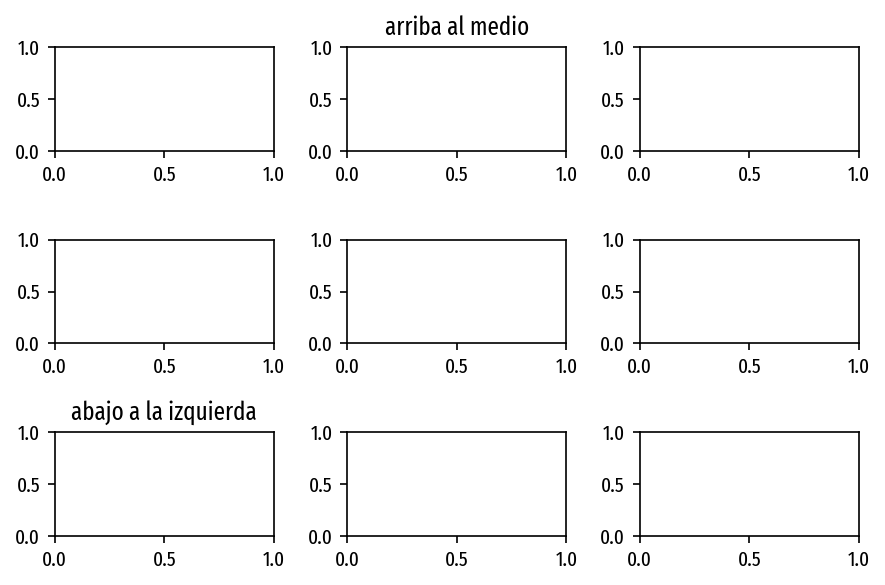

In [37]:
fig, axes = plt.subplots(3, 3)

axes[0,1].set_title('arriba al medio')
axes[2,0].set_title('abajo a la izquierda')

fig.tight_layout()

In [38]:
import matplotlib.gridspec as gridspec

Luego, configuramos los radios de aspecto que tendrán cada fila y columna de la grilla:

In [39]:
width_ratios = [1.0, 1.0, 1.0]

In [40]:
height_ratios = [0.45, 5.5, 0.1, 1.0, 0.3]

Finalmente procedemos a graficar la grilla. Las variables `h_space` y `w_space` se refieren al espacio entre cada fila y cada columna, que permite agregar texto (como etiquetas de ejes y títulos). La variable `fig_scale` la utilizaremos para determinar el tamaño final de la visualización. Noten que los `width_ratios` y `height_ratios` los multiplicamos por el radio de aspecto del mapa, de modo que el mapa no se vea deformado.

/home/egraells/miniconda3/envs/mobility/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:418: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
/home/egraells/miniconda3/envs/mobility/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:418: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():


Text(0.01, 0.99, '¿Cómo se vería la vida en Santiago desde arriba? Cada habitante tiene una ciudad única en base a sus experiencias.\nLa Encuesta Origen-Destino 2012 de Santiago nos permite analizar esas experiencias a partir de los viajes que\nrealizan sus habitantes. En esta visualización los hemos separado en cinco quintiles de acuerdo al ingreso de cada\nhogar. El quintil de ingreso más bajo es Q1 (con un ingreso por hogar de 250.000 pesos) y el quintil de ingreso\nmás alto es Q5 (desde 1 millón de pesos hacia arriba).')

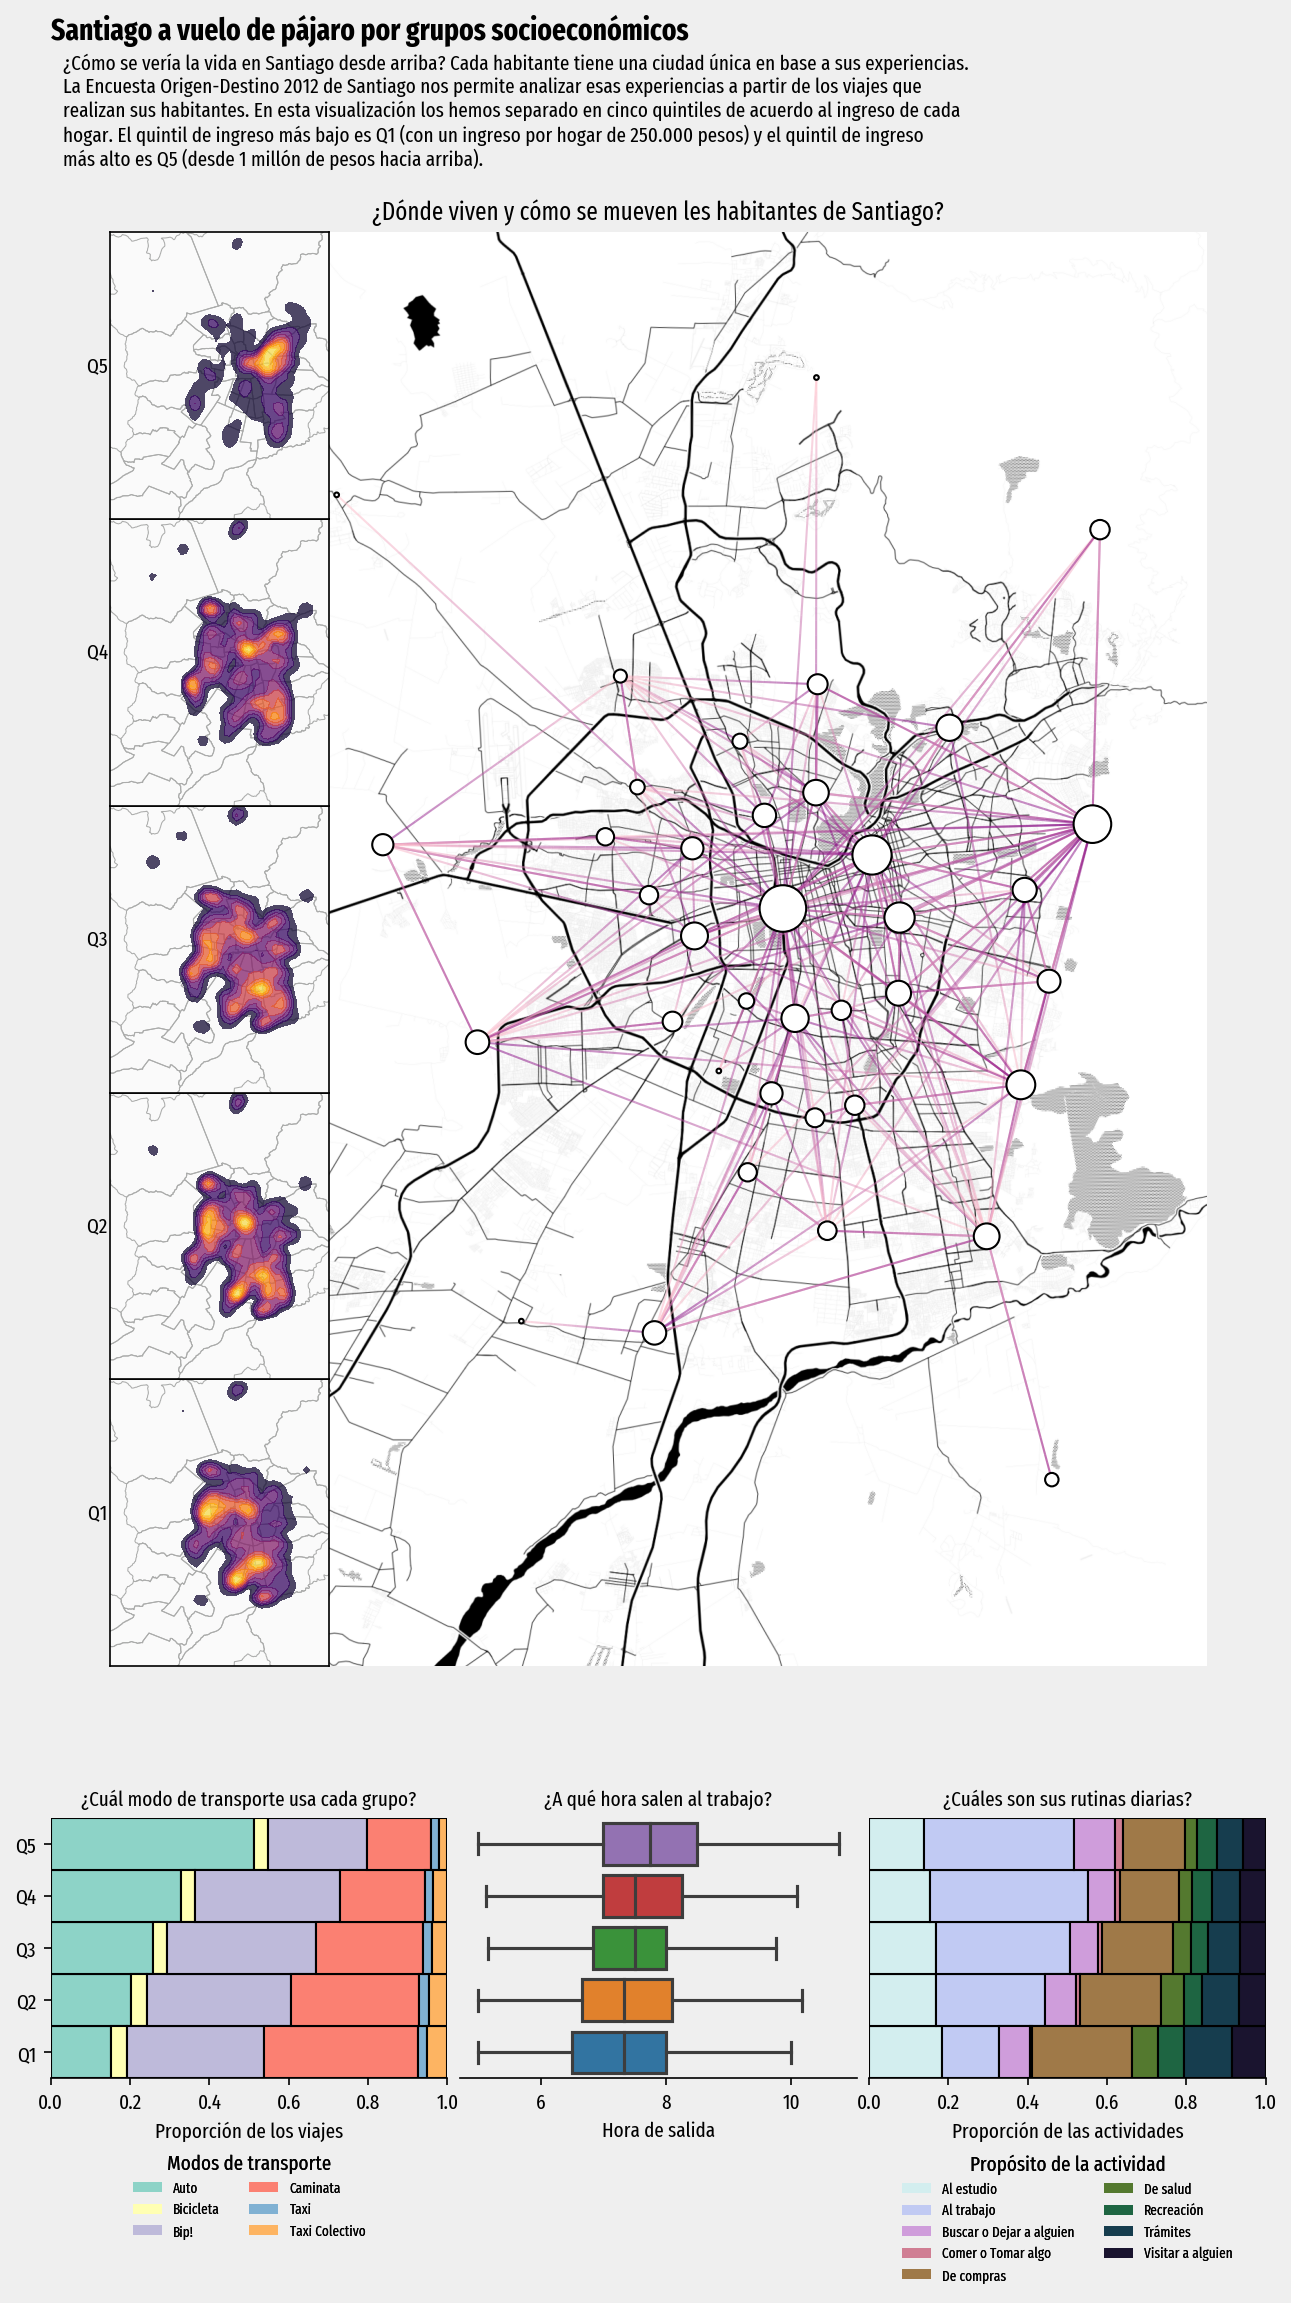

In [41]:
from aves.visualization.colors import categorical_color_legend

fig_scale = 2

h_space = 0.1
w_space = 0.05

y_size = sum(height_ratios) * fig_scale
x_size = map_aspect_ratio * height_ratios[1] * fig_scale


fig = plt.figure(figsize=(x_size, y_size))
fig.set_facecolor('#efefef')

gs = gridspec.GridSpec(
    len(height_ratios),
    len(width_ratios),
    figure=fig,
    hspace=h_space,
    wspace=w_space,
    width_ratios=width_ratios,
    height_ratios=height_ratios,
)

ax_intro = fig.add_subplot(gs[0,:])
ax_overview = fig.add_subplot(gs[1,:])

ax_left = fig.add_subplot(gs[3, 0])
ax_center = fig.add_subplot(gs[3, 1])
ax_right = fig.add_subplot(gs[3, 2])

mode_legend_ax = fig.add_subplot(gs[4, 0])
purpose_legend_ax = fig.add_subplot(gs[4, 2])

ax_intro.set_title("Santiago a vuelo de pájaro por grupos socioeconómicos", loc="left", fontweight='bold', fontsize='x-large')
ax_intro.set_axis_off()

ax_overview.set_axis_off()
ax_overview.set_title('¿Dónde viven y cómo se mueven les habitantes de Santiago?')
plot_maps(ax_overview)

ax_left.set_title("¿Cuál modo de transporte usa cada grupo?", fontsize='medium')
plot_mode_usage(ax_left)
ax_left.set_xlabel('Proporción de los viajes')

ax_center.set_title("¿A qué hora salen al trabajo?", fontsize='medium')
plot_boxplots(ax_center)
ax_center.set_yticks([])
ax_center.set_xlabel('Hora de salida')

ax_right.set_title("¿Cuáles son sus rutinas diarias?", fontsize='medium')
plot_purposes(ax_right)
ax_right.set_yticks([])
ax_right.set_xlabel('Proporción de las actividades')

categorical_color_legend(
    mode_legend_ax,
    mode_colors,
    modes,
    n_columns=2,
    loc="upper center",
    fontsize="x-small",
    title='Modos de transporte'
)
mode_legend_ax.set_axis_off()

categorical_color_legend(
    purpose_legend_ax,
    purpose_colors,
    purposes,
    n_columns=2,
    loc="upper center",
    fontsize="x-small",
    title='Propósito de la actividad'
)
purpose_legend_ax.set_axis_off()

gs.tight_layout(fig, pad=0)

ax_intro.annotate("""
¿Cómo se vería la vida en Santiago desde arriba? Cada habitante tiene una ciudad única en base a sus experiencias.
La Encuesta Origen-Destino 2012 de Santiago nos permite analizar esas experiencias a partir de los viajes que
realizan sus habitantes. En esta visualización los hemos separado en cinco quintiles de acuerdo al ingreso de cada
hogar. El quintil de ingreso más bajo es Q1 (con un ingreso por hogar de 250.000 pesos) y el quintil de ingreso
más alto es Q5 (desde 1 millón de pesos hacia arriba).""".strip(), (0.01, 0.99), ha='left', va='top', wrap=True)

